In [63]:
import os, sys
project_dir = os.path.join(os.getcwd(),'..')
if project_dir not in sys.path:
    sys.path.append(project_dir)


sparse_dir = os.path.join(project_dir, 'modules/Sparse')
if sparse_dir not in sys.path:
    sys.path.append(sparse_dir)

from matplotlib import pyplot as plt

# Dataset

In [201]:
import torch
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import Subset, DataLoader

dataset_full = MNIST('data/', train = True, download = True, transform = transforms.ToTensor())
# idx = torch.where((dataset_full.targets == 0) | (dataset_full.targets == 2))[0]
normal_idx = torch.where((dataset_full.targets == 4))[0]
anomaly_idx = torch.where((dataset_full.targets == 9))[0]
idx = torch.cat([normal_idx, anomaly_idx[:512]])

x_train_set = Subset(dataset_full, idx)
train_loader =  DataLoader(x_train_set, 256, shuffle=True)

tensor(4)


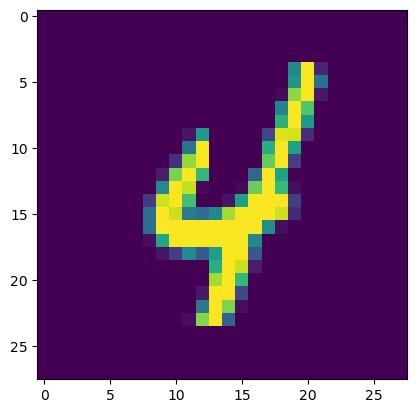

In [202]:
# TO REMOVE! Just testing!
x, y = next(iter(train_loader))
plt.imshow(x[0,0])
print(y[0])

In [235]:
from Sparse.modules.variational import VariationalLayer
from Sparse.modules.variational.utils import SGVBL
from torch.nn.parameter import Parameter
import torch.nn.functional as F

from torch import nn
class VariationalEncoder(nn.Linear, nn.Module):
    def __init__(self, in_features, out_features, bias=True) -> None:
        super(VariationalEncoder, self).__init__(in_features, out_features, bias)
        self.log_sigma_weight = Parameter(torch.Tensor(out_features, in_features))
        self.log_sigma_bias = Parameter(torch.Tensor(out_features))
        torch.nn.init.xavier_uniform_(self.log_sigma_weight)
        self.log_sigma_bias.data.fill_(0)
        self.mu, self.sigma = None, None

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        mu = F.linear(x, self.weight, self.bias) 
        # sigma = torch.exp(F.linear(x, self.log_sigma_weight))
        sigma = torch.exp(0.5 * F.linear(x, self.log_sigma_weight, self.log_sigma_bias))

        if self.training:
            self.mu, self.sigma = mu, sigma

        # Reparameterization trick
        eps = torch.normal(0, torch.ones_like(sigma))
        return mu + sigma * eps

    def kl_reg(self):
        # KL-Divergence regularization $D_{KL}(\mathcal{N}(;\mu_\theta, \sigma_\theta) | \mathcal{N}(;\0, I))$
        # More details in https://arxiv.org/abs/1312.6114.
        return .5 * (self.mu**2 + self.sigma**2 - torch.log(self.sigma**2) - 1).sum()

In [247]:
from torch import nn

class VAE(nn.Module):
    def __init__(self, input_size, latent_space):
        super(VAE, self).__init__()
        conv_out_size = input_size // (2*2)
        self.encoder = nn.Sequential(
            nn.Conv2d(1,8, 3, stride=1, padding=1),
            nn.Dropout2d(0.5),
            nn.ReLU(),
            nn.MaxPool2d(3, stride=2, padding=1),
            nn.Conv2d(8, 12, 3, stride=1, padding=1),
            nn.Dropout2d(0.5),
            nn.ReLU(),
            nn.MaxPool2d(3, stride=2, padding=1),
            nn.Flatten(),
            nn.Linear(12*(conv_out_size**2), 128),
            nn.Dropout(0.5),
            nn.ReLU(),
        )

        self.botleneck = VariationalEncoder(128, latent_space)

        self.decoder = nn.Sequential(
            nn.Linear(latent_space, 128),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(128, 12*(conv_out_size**2)),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Unflatten(1, (12, conv_out_size, conv_out_size)),
            nn.Conv2d(12, 8, 3, stride=1, padding=1),
            nn.Dropout2d(0.5),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(8, 1, 3, stride=1, padding=1),
            nn.Upsample(scale_factor=2),
            nn.Sigmoid()
        )


    def forward(self, x:torch.Tensor) -> torch.Tensor:
        x = self.encoder(x)
        x = self.botleneck(x)
        x = self.decoder(x)
        return x

model = VAE(28, 2)
from torch.nn.functional import mse_loss
sgvbl = SGVBL(model, len(x_train_set), loss=mse_loss)

In [248]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.train()
n_epochs = 100
from tqdm import tqdm
kl_weight = 0.02

opt = torch.optim.Adam(model.parameters())
for epoch in tqdm(range(n_epochs)):
    kl_weight = min(kl_weight+0.005, 1)
    for x, y in train_loader:
        x = x.to(device) # GPU
        opt.zero_grad()
        x_hat = model(x)
        loss = sgvbl(x, x_hat, kl_weight)
        loss.backward()
        opt.step()

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [01:13<00:00,  1.37it/s]


In [249]:
def plot_latent(autoencoder, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        z = autoencoder.botleneck(autoencoder.encoder(x.to(device)))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break

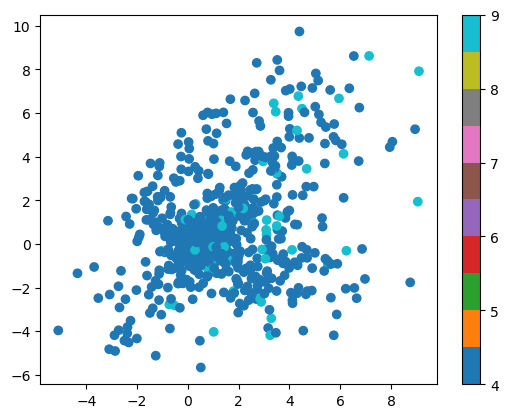

In [255]:
model.eval()
# model.train()
plot_latent(model, train_loader, num_batches=1)

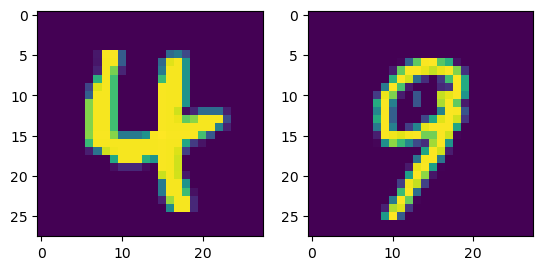

In [256]:
x, y = next(iter(train_loader))
x_0 = x[torch.argwhere(y==4).squeeze()[0]].unsqueeze(0)
x_1 = x[torch.argwhere(y==9).squeeze()[0]].unsqueeze(0)

plt.subplot(1,2,1)
plt.imshow(x_0[0,0])
plt.subplot(1,2,2)
plt.imshow(x_1[0,0])
model.train()
z_0, z_1 = [], []
for i in range(100):
    z_0.append(model.botleneck(model.encoder(x_0.to(device))).detach().cpu())
    z_1.append(model.botleneck(model.encoder(x_1.to(device))).detach().cpu())

In [257]:
x.shape

torch.Size([256, 1, 28, 28])

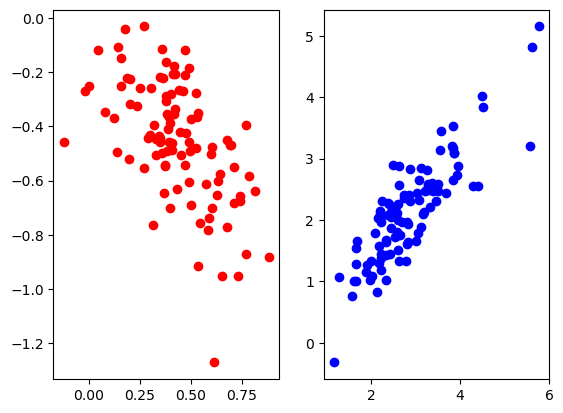

In [258]:
plt.subplot(1,2,1)
plt.scatter(torch.cat(z_0)[:,0], torch.cat(z_0)[:,1], c='r')
plt.subplot(1,2,2)
plt.scatter(torch.cat(z_1)[:,0], torch.cat(z_1)[:,1], c='b')

In [259]:
x = torch.cat([x_0, x_1]).to(device)
model.train()
with torch.no_grad():
    x_hat = model(x)

model.botleneck.sigma, model.botleneck.mu

(tensor([[2.5853e-03, 1.0633e-03],
         [4.9232e-05, 8.7230e-06]], device='cuda:0'),
 tensor([[ 0.6491, -0.9471],
         [ 2.3529,  2.0131]], device='cuda:0'))

In [244]:
import numpy as np
def plot_reconstructed(autoencoder, r0=(-40, 10), r1=(-20, 10), n=12):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = autoencoder.decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])

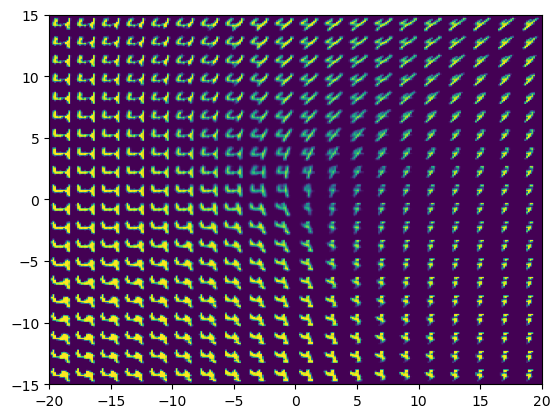

In [245]:
model.eval()
plot_reconstructed(model.to(device), r0=(-20, 20), r1=(-15, 15), n=20)

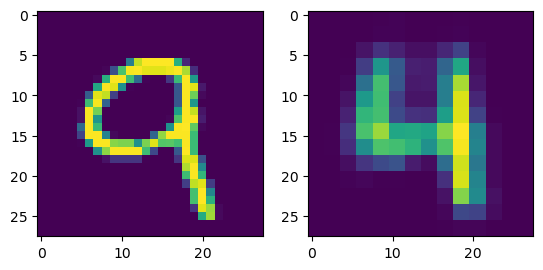

In [246]:
x = next(iter(train_loader))[0]
plt.subplot(1,2,1)
plt.imshow(x[0,0])

plt.subplot(1,2,2)
plt.imshow(model(x.cuda()).detach().cpu()[0,0])

## MedMNIST

In [99]:
import medmnist
from medmnist import INFO, Evaluator
import torch.utils.data as data


print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v2.2.2 @ https://github.com/MedMNIST/MedMNIST/


In [100]:
data_flag = 'pneumoniamnist'
# data_flag = 'breastmnist'
download = True

NUM_EPOCHS = 3
BATCH_SIZE = 128
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [101]:

# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

Using downloaded and verified file: /home/abian/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /home/abian/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /home/abian/.medmnist/pneumoniamnist.npz


In [102]:
next(iter(test_loader))[0].shape

torch.Size([256, 1, 28, 28])

/home/abian/Workspace/Anaconda/envs/DeepLearning/lib/python3.10/site-packages/medmnist/utils.py:31: FutureWarning: `multichannel` is a deprecated argument name for `montage`. It will be removed in version 1.0. Please use `channel_axis` instead.
  montage_arr = skimage_montage(sel_img, multichannel=(n_channels == 3))


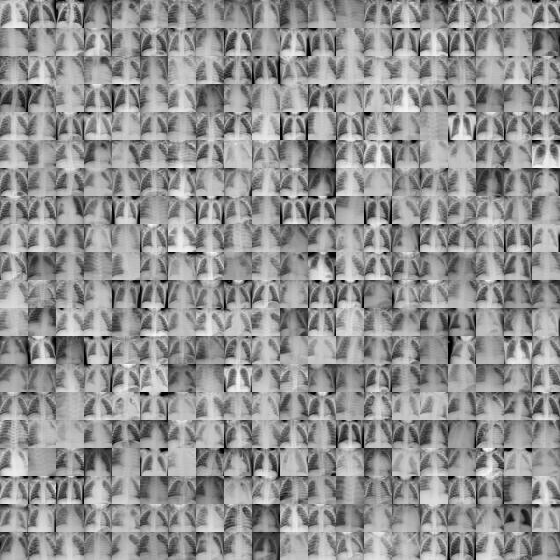

In [103]:
train_dataset.montage(length=20)

In [104]:
train_dataset.labels
normal_idx = torch.tensor(np.where((train_dataset.labels == 0))[0])
anomaly_idx = torch.tensor(np.where((train_dataset.labels == 1))[0])

idx = torch.cat([normal_idx, anomaly_idx[:512]])

x_train_set = Subset(train_dataset, idx)
train_loader =  DataLoader(x_train_set, 256, shuffle=True)
# normal_idx = torch.where((dataset_full.targets == 7))[0]
# anomaly_idx = torch.where((dataset_full.targets == 1))[0]

In [105]:
model = VAE(28, 2)
from torch.nn.functional import mse_loss
sgvbl = SGVBL(model, len(x_train_set), loss=mse_loss)

In [106]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.train()
n_epochs = 200
from tqdm import tqdm
kl_weight = 0.02

opt = torch.optim.Adam(model.parameters())
for epoch in tqdm(range(n_epochs)):
    kl_weight = min(kl_weight+0.006, 1)
    for x, y in train_loader:
        x = x.to(device) # GPU
        opt.zero_grad()
        x_hat = model(x)
        loss = sgvbl(x, x_hat, kl_weight)
        loss.backward()
        opt.step()

100%|██████████| 200/200 [00:56<00:00,  3.53it/s]


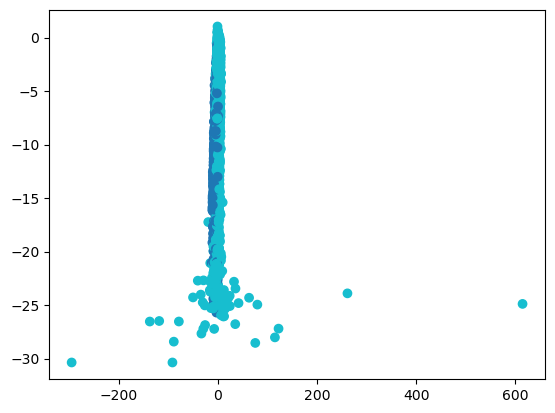

In [163]:
model.eval()
# model.train()
plot_latent(model, train_loader_at_eval, num_batches=100)

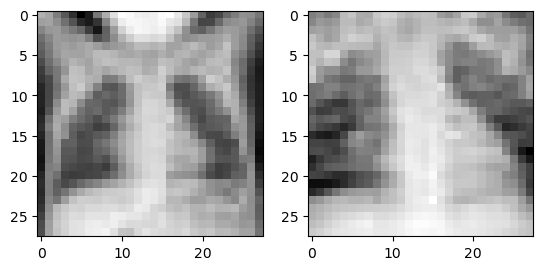

In [181]:
x, y = next(iter(train_loader))
x_0 = x[torch.argwhere(y==0)[0].squeeze()[0]].unsqueeze(0)
x_1 = x[torch.argwhere(y==1)[0].squeeze()[0]].unsqueeze(0)

plt.subplot(1,2,1)
plt.imshow(x_0[0,0], cmap='gray')
plt.subplot(1,2,2)
plt.imshow(x_1[0,0], cmap='gray')
model.train()
z_0, z_1 = [], []
for i in range(100):
    z_0.append(model.botleneck(model.encoder(x_0.to(device))).detach().cpu())
    z_1.append(model.botleneck(model.encoder(x_1.to(device))).detach().cpu())

In [182]:
x = torch.cat([x_0, x_1])
z = model.botleneck(model.encoder(x.to(device))).detach().cpu()
model.botleneck.sigma, model.botleneck.mu

(tensor([[6.6367e-02, 2.4586e-06],
         [8.4299e-01, 1.4664e-04]], device='cuda:0', grad_fn=<ExpBackward0>),
 tensor([[ 0.2575, 10.5250],
         [-0.7691,  3.1224]], device='cuda:0', grad_fn=<AddmmBackward0>))

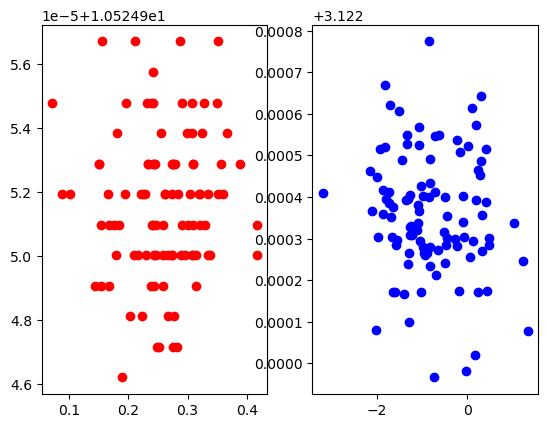

In [183]:
plt.subplot(1,2,1)
plt.scatter(torch.cat(z_0)[:,0], torch.cat(z_0)[:,1], c='r')
plt.subplot(1,2,2)
plt.scatter(torch.cat(z_1)[:,0], torch.cat(z_1)[:,1], c='b')

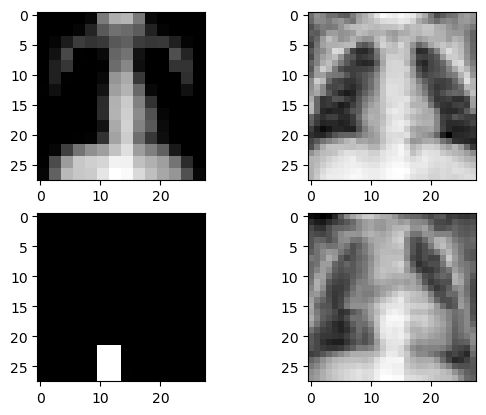

In [180]:
x_hat = model(x_0.to(device))
plt.subplot(2,2,1)
plt.imshow(x_hat[0,0].detach().cpu(), cmap='gray')
plt.subplot(2,2,2)
plt.imshow(x_0[0,0], cmap='gray')

x_hat = model(x_1.to(device))
plt.subplot(2,2,3)
plt.imshow(x_hat[0,0].detach().cpu(), cmap='gray')
plt.subplot(2,2,4)
plt.imshow(x_1[0,0], cmap='gray')

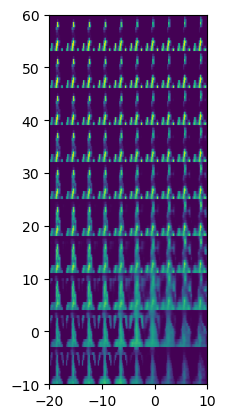

In [159]:
model.eval()
plot_reconstructed(model, r0=(-20, 10), r1=(-10, 60), n=10)